In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
import os

filename = 'preprocessed_model_data.csv'
if not os.path.exists(filename):
    from google.colab import files
    print(f"{filename} not found: please upload it now.")
    uploaded = files.upload()  # This will prompt upload if needed

df = pd.read_csv(filename)
print(df.head())



   Attendance_Encoded  StudyHours_Encoded  Assignments_Encoded  \
0               0.825                15.0                    3   
1               0.950                 5.0                    3   
2               0.450                 5.0                    1   
3               0.620                15.0                    2   
4               0.950                 5.0                    3   

   PartTimeJob_Encoded  Extracurriculars_Encoded  GPA_Normalized  \
0                    1                       0.5        0.190909   
1                    0                       1.0        0.518182   
2                    1                       0.0        0.476348   
3                    0                       1.0        0.609091   
4                    0                       0.0        0.476348   

   Average_Grade  
0       3.300000  
1       2.925000  
2       1.233333  
3       3.000000  
4       1.900000  


In [3]:
# Feature columns: all columns except the target
features = [col for col in df.columns if col != 'Average_Grade']
target = 'Average_Grade'

X = df[features].values
y = df[target].values


In [4]:
print(np.isnan(X).sum(), np.isnan(y).sum())


1 0


In [5]:
import numpy as np

# Create DataFrame for features and target to easily drop any NaNs at once
data = pd.DataFrame(X, columns=features)
data['Average_Grade'] = y
data = data.dropna()
X = data[features].values
y = data['Average_Grade'].values


In [6]:
print(np.isfinite(X).all())
# Should print True

print(np.isnan(X).sum(), np.isnan(y).sum())
# Should both print 0


True
0 0


In [7]:
df = df.dropna(subset=[target])


In [8]:
keras.layers.Dense(1)  # no activation, defaults to 'linear'


<Dense name=dense, built=False>

In [9]:
# 85% training, 15% testing (adjust split if you prefer)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")


Train shape: (90, 6), (90,)
Test shape: (17, 6), (17,)


In [10]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
print(np.isinf(X_train).sum(), np.isinf(y_train).sum())
# all should print 0


0 0
0 0


In [11]:
print(df[features + [target]].isnull().sum())


Attendance_Encoded          0
StudyHours_Encoded          1
Assignments_Encoded         0
PartTimeJob_Encoded         0
Extracurriculars_Encoded    0
GPA_Normalized              0
Average_Grade               0
dtype: int64


In [12]:
df['StudyHours_Encoded'] = df['StudyHours_Encoded'].fillna(df['StudyHours_Encoded'].mean())


In [13]:
print(df[features + [target]].isnull().sum())

Attendance_Encoded          0
StudyHours_Encoded          0
Assignments_Encoded         0
PartTimeJob_Encoded         0
Extracurriculars_Encoded    0
GPA_Normalized              0
Average_Grade               0
dtype: int64


In [14]:
# Model Architecture2: Deeper MLP
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Experimentable with different optimizers (Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Create EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',        # What to monitor (validation loss)
    patience=30,              # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Keeps the best weights (lowest val_loss)
)

# Then pass to model.fit() like this:
history = model.fit(
    X_train, y_train,
    epochs=500,                # Or any large number, training will usually stop earlier
    batch_size=10,
    validation_split=0.2,
    callbacks=[early_stop],    # Add the callback here
    verbose=1
)


Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 8.7251 - mae: 2.8674 - val_loss: 7.3446 - val_mae: 2.5851
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.1801 - mae: 2.4037 - val_loss: 4.0502 - val_mae: 1.7961
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8643 - mae: 1.5326 - val_loss: 2.0806 - val_mae: 1.2345
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3636 - mae: 0.9609 - val_loss: 3.0640 - val_mae: 1.4467
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4171 - mae: 0.9794 - val_loss: 2.2710 - val_mae: 1.2741
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1215 - mae: 0.8862 - val_loss: 1.7694 - val_mae: 1.1164
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1639 - mae: 0.9038 - val_loss: 1.6158 - val_mae: 1.0667
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0983 - mae: 0.8953 - val_loss: 1.6610 - val_mae: 1.0899
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0010 - mae: 

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the training data
y_pred_train = model.predict(X_train).flatten()


mse = mean_squared_error(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print(f"Train MSE: {mse:.4f}")
print(f"Train MAE: {mae:.4f}")
print(f"Train R2: {r2:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Train MSE: 0.3207
Train MAE: 0.4667
Train R2: 0.2690


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test).flatten()  # Make predictions on the test data

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Test MSE: 0.3573
Test MAE: 0.4943
Test R2: 0.1414


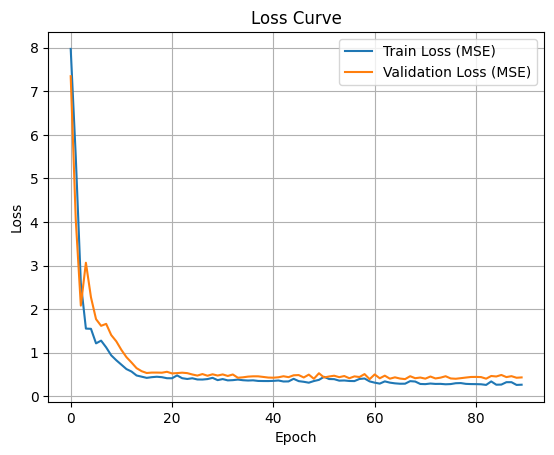

In [19]:
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


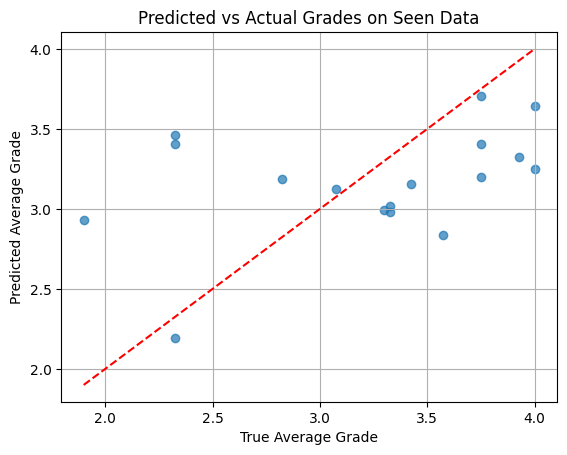

In [20]:
y_pred = model.predict(X_test).flatten()
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('True Average Grade')
plt.ylabel('Predicted Average Grade')
plt.title('Predicted vs Actual Grades on Seen Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True)
plt.show()


In [21]:
df = pd.read_csv('preprocessed_model_data.csv')
print(df.head())

   Attendance_Encoded  StudyHours_Encoded  Assignments_Encoded  \
0               0.825                15.0                    3   
1               0.950                 5.0                    3   
2               0.450                 5.0                    1   
3               0.620                15.0                    2   
4               0.950                 5.0                    3   

   PartTimeJob_Encoded  Extracurriculars_Encoded  GPA_Normalized  \
0                    1                       0.5        0.190909   
1                    0                       1.0        0.518182   
2                    1                       0.0        0.476348   
3                    0                       1.0        0.609091   
4                    0                       0.0        0.476348   

   Average_Grade  
0       3.300000  
1       2.925000  
2       1.233333  
3       3.000000  
4       1.900000  


In [22]:
features = [col for col in df.columns if col != 'Average_Grade']
target = 'Average_Grade'

X = df[features].values
y = df[target].values

In [23]:
y_pred = model.predict(X_test).flatten()  # Makes prediction for each test sample


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [24]:
# Define the numeric-to-letter grade conversion function
def numeric_to_letter_grade(avg_grade):
    if avg_grade >= 3.7:
        return 'A'
    elif avg_grade >= 3.3:
        return 'A-'
    elif avg_grade >= 3.0:
        return 'B+'
    elif avg_grade >= 2.7:
        return 'B'
    elif avg_grade >= 2.3:
        return 'B-'
    elif avg_grade >= 2.0:
        return 'C+'
    elif avg_grade >= 1.7:
        return 'C'
    elif avg_grade >= 1.3:
        return 'C-'
    elif avg_grade >= 1.0:
        return 'D+'
    elif avg_grade >= 0.7:
        return 'D'
    else:
        return 'E'

# Convert both actual and predicted numeric grades to letter grades
letter_preds = [numeric_to_letter_grade(x) for x in y_pred]
letter_actuals = [numeric_to_letter_grade(x) for x in y_test]

# Build and display/save the comparison table
import pandas as pd

results = pd.DataFrame({
    'Actual (Num)': y_test,
    'Actual (Letter)': letter_actuals,
    'Predicted (Num)': y_pred,
    'Predicted (Letter)': letter_preds
})

print(results.head())

   Actual (Num) Actual (Letter)  Predicted (Num) Predicted (Letter)
0         3.325              A-         2.980700                  B
1         3.575              A-         2.836869                  B
2         1.900               C         2.931214                  B
3         3.425              A-         3.154286                 B+
4         3.750               A         3.403283                 A-


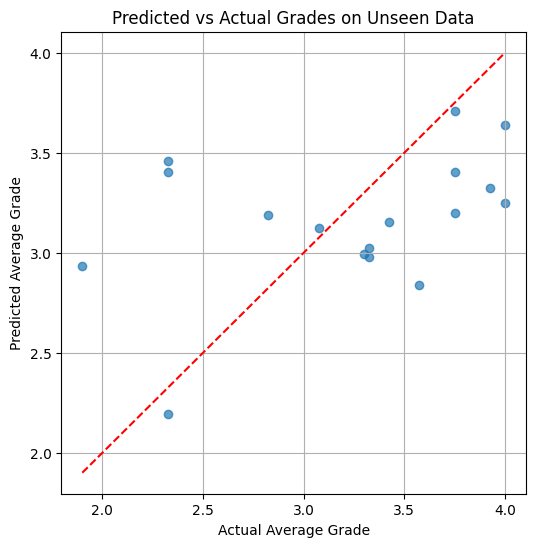

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Average Grade')
plt.ylabel('Predicted Average Grade')
plt.title('Predicted vs Actual Grades on Unseen Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # reference line y=x
plt.grid(True)
plt.show()


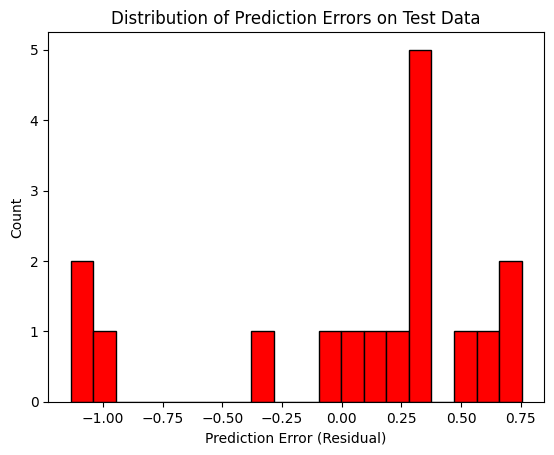

In [26]:
residuals = y_test - y_pred
plt.figure()
plt.hist(residuals, bins=20, color='red', edgecolor='black')
plt.xlabel('Prediction Error (Residual)')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors on Test Data')
plt.grid(False)
plt.show()


In [27]:
# Save true and predicted values for further analysis
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.to_csv('model_test_results.csv', index=False)


In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Fit the scaler on the 'GPA_Normalized' column
gpa_col = "GPA_Normalized"
# Assuming df is already loaded and preprocessed as in previous cells
# Ensure the 'GPA_Normalized' column is numeric and handle NaNs before fitting the scaler
df[gpa_col] = pd.to_numeric(df[gpa_col], errors='coerce')
df[gpa_col] = df[gpa_col].fillna(df[gpa_col].mean()) # Fill NaNs if any

gpa_scaler = MinMaxScaler()
gpa_scaler.fit(df[[gpa_col]])


def predict_manual(model, gpa_scaler):
    # Prompt for specific attendance percentage
    while True:
        try:
            attendance_val = float(input("Enter your attendance percentage (e.g., 87.5 for 87.5%): "))
            break
        except ValueError:
            print("Please enter a valid number.\n")
    # Normalize attendance to the scale used for training, if needed
    # If you used percentage/100 as feature, then just divide by 100 here
    attendance_encoded = attendance_val / 100

    # Prompt for study hours
    while True:
        try:
            study_hours = float(input("Enter the number of study hours per week (e.g., 16): "))
            break
        except ValueError:
            print("Please enter a valid number.\n")

    # Prompt for assignment completion (as a number or percentage)
    while True:
        try:
            assignments = float(input("On average, what fraction of assignments do you submit on time? (e.g., 1 = 100%, 0.8 = 80%): "))
            break
        except ValueError:
            print("Please enter a value between 0 and 1, e.g., 0.8 for 80%.\n")

    # Part time job (yes/no)
    while True:
        job_raw = input("Are you currently doing a part time job? (yes/no): ").strip().lower()
        if job_raw == 'yes':
            job = 1
            break
        elif job_raw == 'no':
            job = 0
            break
        else:
            print("Please enter 'yes' or 'no'.\n")

    # Extracurricular activities
    while True:
        extra_raw = input("Are you involved in extracurricular activities? (yes/no/occasionally): ").strip().lower()
        if extra_raw == 'yes':
            extra = 1
            break
        elif extra_raw == 'no':
            extra = 0
            break
        elif extra_raw == 'occasionally':
            extra = 0.5
            break
        else:
            print("Please enter 'yes', 'no', or 'occasionally'.\n")

    # GPA (raw, then normalize)
    while True:
        try:
            gpa_raw = float(input("Enter your GPA (e.g., 3.25): ").strip())
            break
        except ValueError:
            print("Please enter a valid GPA number (e.g., 2.85, 3.14).\n")

    gpa_norm = gpa_scaler.transform([[gpa_raw]])[0][0]

    # Build feature array
    features_input = np.array([[attendance_encoded, study_hours, assignments, job, extra, gpa_norm]])

    pred = model.predict(features_input)[0][0]

    # Numeric to letter grade mapping
    def numeric_to_letter_grade(avg_grade):
        if avg_grade >= 3.7: return 'A'
        elif avg_grade >= 3.3: return 'A-'
        elif avg_grade >= 3.0: return 'B+'
        elif avg_grade >= 2.7: return 'B'
        elif avg_grade >= 2.3: return 'B-'
        elif avg_grade >= 2.0: return 'C+'
        elif avg_grade >= 1.7: return 'C'
        elif avg_grade >= 1.3: return 'C-'
        elif avg_grade >= 1.0: return 'D+'
        elif avg_grade >= 0.7: return 'D'
        else: return 'E'

    letter_grade = numeric_to_letter_grade(pred)
    print(f"\nPredicted Average Grade (numeric): {pred:.2f}")
    print(f"Predicted Average Grade (as letter): **{letter_grade}**")

In [ ]:
predict_manual(model, gpa_scaler)